In [1]:
import pickle
import numpy as np
from math import *
from scipy import ndimage
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline

In [2]:
# Function to plot the contour of the 2D pattern of U[tu] and V[tv]
def plot_pattern(U, V, tu, tv, filled=True):
    
    # 2D meshgrid setup
    x = np.linspace(0, (Nx-1)*h, Nx)
    y = np.linspace(0, (Ny-1)*h, Ny)
    X, Y = np.meshgrid(x, y)
    
    # Countour plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    extent = [x[0], x[-1], y[0], y[-1]]
    levelsU = np.linspace(np.amin(U), np.amax(U), 20) 
    levelsV = np.linspace(np.amin(V), np.amax(V), 20)  

    if not filled and tu!=0 and tv!=0:
        csU = axes[0].contour(X, Y, U[tu], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        csV = axes[1].contour(X, Y, V[tv], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)        
    else:
        csU = axes[0].contourf(X, Y, U[tu], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        csV = axes[1].contourf(X, Y, V[tv], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)
    
    cbarU = fig.colorbar(csU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(csV, ax=axes[1], shrink=0.8)
    
    axes[0].set_title('U at n = %s, time = %.2f sec' % (tu, tu*dt), fontsize=16)
    axes[1].set_title('V at n = %s, time = %.2f sec' % (tv, tv*dt), fontsize=16)
    
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    
    fig.tight_layout()

    plt.show()

# Function to animate the contour plot of the 2D pattern of U, V
def animate_pattern(U, V, Nt, Nout):
    """
    Nt:   Total number of timesteps to animate
    Nout: Plot figure per Nout timesteps 
    """
    x = np.linspace(0, (Nx-1)*h, Nx)
    y = np.linspace(0, (Ny-1)*h, Ny)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(14,7))

    extent = [x[0], x[-1], y[0], y[-1]]
    levelsU = np.linspace(np.amin(U), np.amax(U), 20)
    levelsV = np.linspace(np.amin(V), np.amax(V), 20)

    csU = axes[0].contourf(X, Y, U[0], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
    csV = axes[1].contourf(X, Y, V[0], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)

    cbarU = fig.colorbar(csU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(csV, ax=axes[1], shrink=0.8)

    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')

    fig.tight_layout()


    def updatefig(i):
        axes[0].clear()
        axes[1].clear()

        axes[0].contourf(X, Y, U[i*Nout], levels = levelsU, extent = extent, cmap=plt.cm.coolwarm)
        axes[1].contourf(X, Y, V[i*Nout], levels = levelsV, extent = extent, cmap=plt.cm.coolwarm)

        axes[0].set_title('U at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
        axes[1].set_title('V at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)


    ani = animation.FuncAnimation(fig, updatefig, frames=int(Nt/Nout), interval=200, blit=False)
    
    return ani 

# Function to animate the imshow plot of the 2D pattern of U, V
def animate_pattern_2(U, V, Nt, Nout):
    """
    Nt:   Total number of timesteps to animate
    Nout: Plot figure per Nout timesteps 
    """
    x = np.linspace(0, (Nx-1)*h, Nx)
    y = np.linspace(0, (Ny-1)*h, Ny)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(1, 2, figsize=(14,7))
    extent = [x[0], x[-1], y[0], y[-1]]

    imU = axes[0].imshow(U[0], origin='lower', extent = extent, animated=True)
    imV = axes[1].imshow(V[0], origin='lower', extent = extent, animated=True)
    cbarU = fig.colorbar(imU, ax=axes[0], shrink=0.8)
    cbarV = fig.colorbar(imV, ax=axes[1], shrink=0.8)
    axes[0].set_title('U at n = %s, time = %.2f sec' % (0, 0*dt), fontsize=16)
    axes[1].set_title('V at n = %s, time = %.2f sec' % (0, 0*dt), fontsize=16)
    # fig.tight_layout()
    

    def updatefig(i):
        global cbarU, cbarV
        cbarU.remove()
        cbarV.remove()

        axes[0].cla()
        axes[1].cla()

        imU = axes[0].imshow(U[i*Nout], origin='lower', extent = extent, animated=True)
        imV = axes[1].imshow(V[i*Nout], origin='lower', extent = extent, animated=True)
        cbarU = fig.colorbar(imU, ax=axes[0], shrink=0.8)
        cbarV = fig.colorbar(imV, ax=axes[1], shrink=0.8)
        axes[0].set_title('U at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
        axes[1].set_title('V at n = %s, time = %.2f sec' % (i*Nout, i*Nout*dt), fontsize=16)
    #     fig.tight_layout()
        return imU, imV
    

    ani = animation.FuncAnimation(fig, updatefig, frames=int(Nt/Nout), interval=200, blit=True)
    
    return ani 

### Forward Euler Method

In [3]:
# Function to compute laplacian of a 2D matrix M with periodic boundary condition
def my_laplacian(M):
    return -4*M + np.roll(M, 1, axis=1) + np.roll(M, -1, axis=1) + np.roll(M, 1, axis=0) + np.roll(M, -1, axis=0)

# Grid setup
Ny, Nx = 129, 129
h = 2
N = Nx*Ny 

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 0.25
end_t = 2000
time_steps = int(end_t/dt)
print(time_steps)
c = dt/(h*h)

# Initial condition
U = np.zeros((time_steps, Ny, Nx))
V = np.zeros((time_steps, Ny, Nx))
U[0][:, :] = 1
V[0][51:60, 51:70] = 1
V[0][61:80, 71:80] = 1

# Generate pattern using own laplace function 
for i in range(1, time_steps):
    U[i,:,:] = Du*c*my_laplacian(U[i-1,:,:])
    V[i,:,:] = Dv*c*my_laplacian(V[i-1,:,:])
    
    U[i,:,:] += -dt*np.multiply(U[i-1,:,:], np.square(V[i-1,:,:])) + dt*ff*(1-U[i-1,:,:]) + U[i-1,:,:]
    V[i,:,:] += dt*np.multiply(U[i-1,:,:], np.square(V[i-1,:,:])) - dt*(kk+ff)*V[i-1,:,:] + V[i-1,:,:]            

np.save('../ndarr_UV/U_fwd', U)
np.save('../ndarr_UV/V_fwd', V)

32000


In [4]:
U_fwd = np.load('../ndarr_UV/U_fwd.npy')
V_fwd = np.load('../ndarr_UV/V_fwd.npy')

dt = 0.25
end_t = 2000
time_steps = int(end_t/dt)
plot_pattern(U_fwd, V_fwd, time_steps-1, time_steps-1, filled=True)

NameError: name 'U_fwd' is not defined

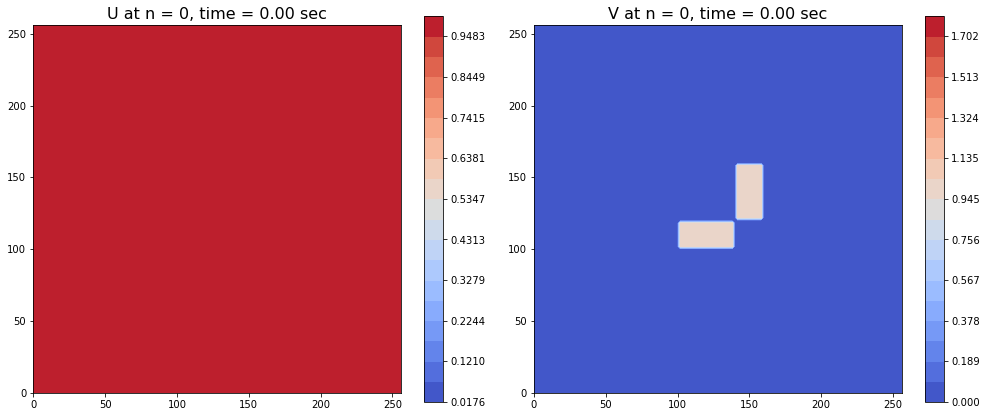

In [5]:
dt = 0.25
end_t = 2000
time_steps = int(end_t/dt)
ani = animate_pattern(U_fwd, V_fwd, Nt=time_steps, Nout=100)
HTML(ani.to_html5_video()) 

In [6]:
# for i in range(1, time_steps):
#     for j in range(m):
#         for k in range(n):
#             s1 = -4*U[i-1][j, k]
#             s2 = -4*V[i-1][j, k]
#             orth_neighbors = np.array([(j-1, k), (j+1, k), (j, k-1), (j, k+1)])
#             for jn, kn in orth_neighbors:
#                 if jn < 0: 
#                     jn += m
#                 if jn >= m: 
#                     jn -= m
#                 if kn < 0:
#                     kn += n
#                 if kn >= n:
#                     kn -= n
#                 s1 += U[i-1][jn, kn]
#                 s2 += V[i-1][jn, kn]
            
#             s1 *= Du*c
#             s2 *= Dv*c
            
#             s1 -= dt*U[i-1][j, k]*(V[i-1][j ,k]**2)
#             s2 += dt*U[i-1][j, k]*(V[i-1][j ,k]**2)
            
#             s1 += dt*ff*(1-U[i-1][j, k])
#             s2 -= dt*(kk+ff)*V[i-1][j, k]
            
#             s1 += U[i-1][j, k]
#             s2 += V[i-1][j, k]
            
#             U[i][j, k] = s1
#             V[i][j, k] = s2

### Backward Euler Method --- v0.0

In [6]:
def Laplace_matrix(Ny, Nx):
    N = Ny*Nx
    I = np.eye(N)
    T = -4*I + np.roll(I, -1, axis=1) + np.roll(I, -Nx, axis=1) + np.roll(I, 1, axis=1) + np.roll(I, Nx, axis=1)
    # Correct vertical boundary values
    for i in range(N):
        if i%Nx == 0: # left vertical boundary
            if i-1 < 0:
                T[i, i+N-1] = 0
            else:
                T[i, i-1] = 0
            T[i, i-1+Nx] = 1
        elif i%Nx == (Nx-1): # right vertical boundary
            if i+1 >= N:
                T[i, i-N+1] = 0
            else:
                T[i, i+1] = 0
            T[i, i+1-Nx] = 1
    return sparse.csr_matrix(T)

# Grid setup
Ny, Nx = 129, 129
h = 2
N = Nx*Ny 

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1
end_t = 2000
time_steps = int(end_t/dt)
print(time_steps)
c = dt/(h*h)

# Construct the transform matrix of U and V
L = Laplace_matrix(Ny, Nx)
Tu = sparse.eye(N) - Du*c*L
Tv = sparse.eye(N) - Dv*c*L

# Factorize Tu, Tv
solve_Tu = sparse.linalg.factorized(Tu.tocsc())
solve_Tv = sparse.linalg.factorized(Tv.tocsc())

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[51:60, 51:70] = 1
V_init[61:80, 71:80] = 1

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())

# Backward Euler 
for i in range(1, time_steps):
    bU = np.multiply((1 - dt*np.square(V1d[i-1]) - dt*ff), U1d[i-1]) + dt*ff
#     U1d[i] = sparse.linalg.spsolve(Tu_s, bU)
    U1d[i] = solve_Tu(bU)
    
    bV = (1 - dt*kk - dt*ff) * V1d[i-1] + dt*np.multiply(U1d[i-1], np.square(V1d[i-1]))
#     V1d[i] = sparse.linalg.spsolve(Tv_s, bV) 
    V1d[i] = solve_Tv(bV)

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

np.save('../ndarr_UV/U_bck', U2d)
np.save('../ndarr_UV/V_bck', V2d)

2000


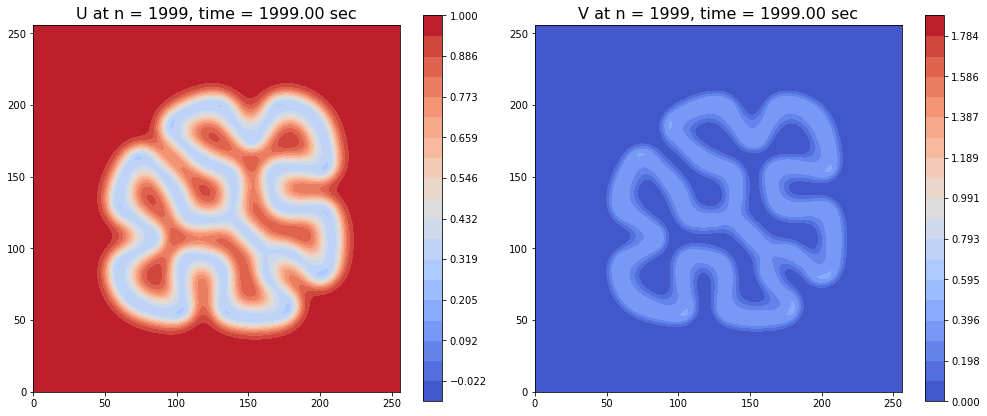

In [7]:
U_bck = np.load('../ndarr_UV/U_bck.npy')
V_bck = np.load('../ndarr_UV/V_bck.npy')

dt = 1
end_t = 2000
time_steps = int(end_t/dt)
plot_pattern(U_bck, V_bck, time_steps-1, time_steps-1)

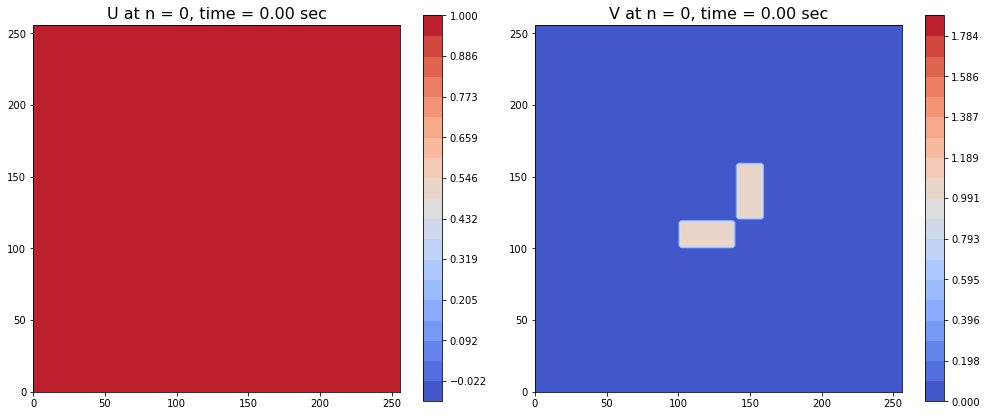

In [9]:
dt = 1
end_t = 2000
time_steps = int(end_t/dt)
ani = animate_pattern(U_bck, V_bck, Nt=time_steps, Nout=100)
HTML(ani.to_html5_video()) 

### Backward Euler Method --- v1.0

In [8]:
def Laplace_matrix_sparse(Ny, Nx):
    N = Nx*Ny

    center = np.ones(N)*(-4)
    west = np.ones(N); west[np.arange(N)%Nx == 0] = 0
    east = np.ones(N); east[np.arange(N)%Nx == Nx-1] = 0

    vals = [center, east, west[1:], 1, 1, 1, 1]
    offsets = np.array([0, 1, -1, Nx, -Nx, -N+Nx, N-Nx])

    D2 = sparse.diags(vals, offsets)

    D2.setdiag(1-west, Nx-1)
    D2.setdiag((1-east)[Nx-1:], 1-Nx)
    
    return D2

# Grid setup
Ny, Nx = 129, 129
h = 2
N = Nx*Ny 

# Parameters setup
Du = 1.0
Dv = 0.5
ff = 0.055
kk = 0.062

# Time steps
dt = 1
end_t = 2000
time_steps = int(end_t/dt)
print(time_steps)
c = dt/(h*h)

# Construct the transform matrix of U and V
L = Laplace_matrix_sparse(Ny, Nx)
Tu = sparse.eye(N) - Du*c*L
Tv = sparse.eye(N) - Dv*c*L

# Factorize Tu, Tv
solve_Tu = sparse.linalg.factorized(Tu.tocsc())
solve_Tv = sparse.linalg.factorized(Tv.tocsc())

# Initial condition
U_init = np.zeros((Ny, Nx))
V_init = np.zeros((Ny, Nx))
U_init[:, :] = 1
V_init[51:60, 51:70] = 1
V_init[61:80, 71:80] = 1

U1d = np.zeros((time_steps, N))
V1d = np.zeros((time_steps, N))
U1d[0] = np.copy(U_init.flatten())
V1d[0] = np.copy(V_init.flatten())


# Backward Euler 
for i in range(1, time_steps):
    bU = np.multiply((1 - dt*np.square(V1d[i-1]) - dt*ff), U1d[i-1]) + dt*ff
#     U1d[i] = sparse.linalg.spsolve(Tu, bU) 
    U1d[i] = solve_Tu(bU)
    
    bV = (1 - dt*kk - dt*ff) * V1d[i-1] + dt*np.multiply(U1d[i-1], np.square(V1d[i-1]))
#     V1d[i] = sparse.linalg.spsolve(Tv, bV) 
    V1d[i] = solve_Tv(bV)

U2d = U1d.reshape((time_steps, Ny, Nx))
V2d = V1d.reshape((time_steps, Ny, Nx))

np.save('../ndarr_UV/U_bck_sparse', U2d)
np.save('../ndarr_UV/V_bck_sparse', V2d)

2000


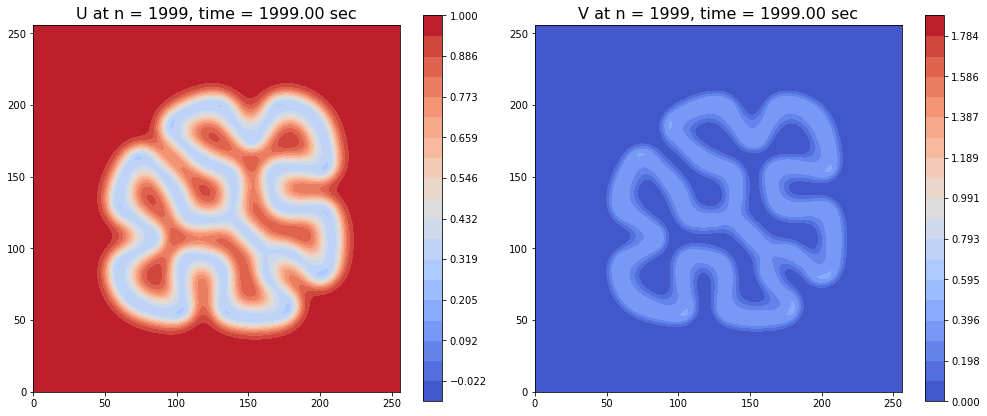

In [9]:
U_bck_sparse = np.load('../ndarr_UV/U_bck_sparse.npy')
V_bck_sparse = np.load('../ndarr_UV/V_bck_sparse.npy')
dt = 1
end_t = 2000
time_steps = int(end_t/dt)
plot_pattern(U_bck_sparse, V_bck_sparse, time_steps-1, time_steps-1)

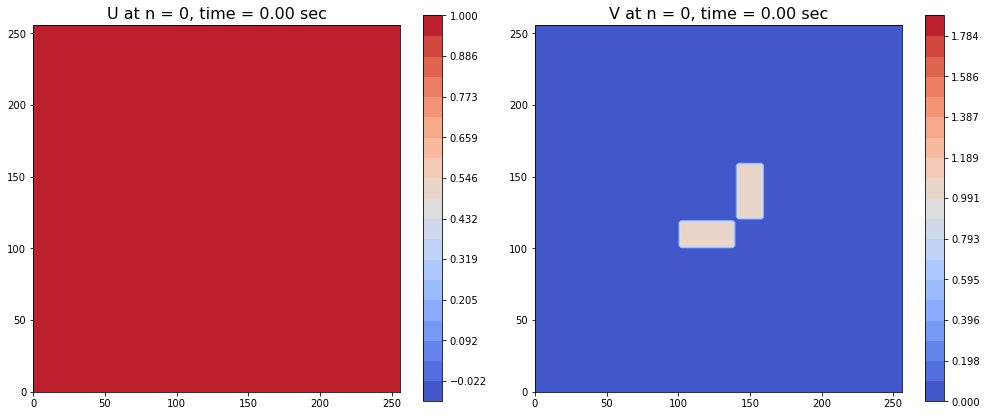

In [12]:
dt = 1
end_t = 2000
time_steps = int(end_t/dt)
ani = animate_pattern(U_bck_sparse, V_bck_sparse, Nt=time_steps, Nout=100)
HTML(ani.to_html5_video()) 

In [13]:
# # Grid setup
# Ny, Nx = 129, 129
# h = 2
# N = Nx*Ny 

# # Parameters setup
# Du = 1.0
# Dv = 0.5
# ff = 0.055
# kk = 0.062

# # Time steps
# dt = 1
# end_t = 2000
# time_steps = int(end_t/dt)
# print(time_steps)
# c = dt/(h*h)

# # Generate the centered difference differentiation matrix for the Laplacian
# vals = np.array([-4, 1, 1, 1, 1, 1, 1, 1, 1])
# offsets = np.array([0, 1, Nx, N-Nx, N-1, -1, -Nx, -N+Nx, -N+1])

# D2 = sparse.diags(vals, offsets, shape=(N, N))

# # LHS matrix 
# A = sparse.eye(N) - Du*c*D2

# # Initial condition
# U1d = np.zeros((time_steps, N))
# V1d = np.zeros((time_steps, N))
# U1d[0] = U[0].flatten()
# V1d[0] = V[0].flatten()

# # Backward Euler 
# for i in range(1, time_steps):
#     bU = np.multiply((1 - dt*np.square(V1d[i-1]) - dt*ff), U1d[i-1]) + dt*ff
#     U1d[i] = sparse.linalg.spsolve(A, bU) 
    
#     bV = (1 - dt*kk - dt*ff) * V1d[i-1] + dt*np.multiply(U1d[i-1], np.square(V1d[i-1]))
#     V1d[i] = sparse.linalg.spsolve(A, bV) 

# U2d = U1d.reshape((time_steps, Ny, Nx))
# V2d = V1d.reshape((time_steps, Ny, Nx))

# plot_pattern(U2d, V2d, time_steps-1, time_steps-1)